# Hotel Ranking 

In this task, we ask you to train a model that learns to `rank properties`.

Hotels.com travellers provide their trip information, like destination, holiday dates and number of people in the search. Our search engine then returns a list of properties, `ranked by their relevance to that traveller`.

We provide you a data set with this travel information augmented by some features we have found to be predictive, including search-level features like booking window (length of time between booking the trip and taking it), and property-level features, like the country the property is in.

Please feel free to model with all, some or none of these, or create your own features.
The label in this data set is `booking_bool`, indicating whether this property was the one that was booked by the customer.
Please provide justification for your metric for this ranking task.

In the leader board, you’ll see the popularity benchmark. This is a useful baseline. It’s the score you’d achieve on the test set if you simply ranked the properties in each search by the number of times it was booked in the training set.
Happy modelling, and good luck!

In [2]:
# import libraries
import shap
import pandas as pd
import seaborn as sns
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import GroupShuffleSplit
pd.options.mode.chained_assignment = None
warnings.simplefilter(action='ignore', category=FutureWarning) # ignore some warning 

## Import data and overview

In [3]:
train = pd.read_csv('train.csv')  # input train data and test data
test = pd.read_csv('test.csv')

In [4]:
train.head() # have a overview of train data

,srch_id,prop_key,srch_date_time,srch_visitor_id,srch_visitor_visit_nbr,srch_visitor_loc_country,srch_visitor_loc_region,srch_visitor_loc_city,srch_visitor_wr_member,srch_posa_continent,...,prop_super_region,prop_continent,prop_country,prop_market_id,prop_submarket_id,prop_room_capacity,prop_review_score,prop_review_count,prop_hostel_bool,srch_local_date
0,-1046322713,257690,2014-09-13 18:37:32,9373b009-4e10-495a-afae-204dd1fe4b7c,5,TWN,TPE,TAIPEI,Signed in - Persistent|WR Member|Remembered FC...,ASIA,...,APAC,ASIA,JAPAN,60041,109140,575,4.1,403.0,0,2014-09-13
1,-1046322713,3066218,2014-09-13 18:37:32,9373b009-4e10-495a-afae-204dd1fe4b7c,5,TWN,TPE,TAIPEI,Signed in - Persistent|WR Member|Remembered FC...,ASIA,...,APAC,ASIA,JAPAN,60041,109140,339,3.6,101.0,0,2014-09-13
2,-1046322713,2271987,2014-09-13 18:37:32,9373b009-4e10-495a-afae-204dd1fe4b7c,5,TWN,TPE,TAIPEI,Signed in - Persistent|WR Member|Remembered FC...,ASIA,...,APAC,ASIA,JAPAN,60041,109140,179,4.1,1189.0,0,2014-09-13
3,-1046322713,3308025,2014-09-13 18:37:32,9373b009-4e10-495a-afae-204dd1fe4b7c,5,TWN,TPE,TAIPEI,Signed in - Persistent|WR Member|Remembered FC...,ASIA,...,APAC,ASIA,JAPAN,60041,98278,272,4.8,221.0,0,2014-09-13
4,-1046322713,3222046,2014-09-13 18:37:32,9373b009-4e10-495a-afae-204dd1fe4b7c,5,TWN,TPE,TAIPEI,Signed in - Persistent|WR Member|Remembered FC...,ASIA,...,APAC,ASIA,JAPAN,60041,109140,198,3.9,702.0,0,2014-09-13


In [5]:
y = train['prop_booking_bool']  # get the labels of data 
train_data = train.drop(['prop_booking_bool'],axis=1) # get the training dataset without label

## Exploratory Data Analysis (EDA)    
1. Analyse the number of searches in train and test dataset and display the distribution for number of hotels in each search
2. Analyse the type of columns 
3. Analyse the missing values 
4. Dataset summary

### 1. Number of searches

In [6]:
train_group = train_data.groupby(by=['srch_id']).count()
print('there are totally '+str(len(train_group))+' searches in training data')
test_group = test.groupby(by=['srch_id']).count()
print('there are totally '+str(len(test_group))+' searches in test data')

there are totally 24013 searches in training data
there are totally 10064 searches in test data


#### Distribution of number of hotels displayed in each search

<AxesSubplot:xlabel='srch_date_time', ylabel='Count'>

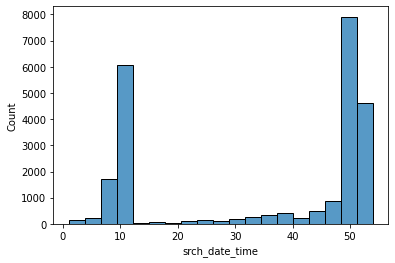

In [7]:
sns.histplot(train_group['srch_date_time'])   ## display the freq of number of hotels in each search

<AxesSubplot:xlabel='srch_date_time', ylabel='Count'>

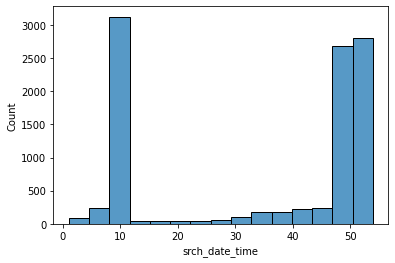

In [8]:
sns.histplot(test_group['srch_date_time'])

### 2. Check the column type

In [9]:
col_types = {}
Dtypes = train_data.dtypes
for col_name in Dtypes.index:
    tmp = col_types.get(Dtypes[col_name],[])
    tmp.append(col_name)
    col_types[Dtypes[col_name]] = tmp

In [10]:
for Type in col_types:
    print('There are '+str(len(col_types[Type]))+ ' columns with type '+ str(Type))
    print(col_types[Type],'\n')

There are 19 columns with type int64
['srch_id', 'prop_key', 'srch_visitor_visit_nbr', 'srch_hcom_destination_id', 'srch_ci_day', 'srch_co_day', 'srch_los', 'srch_bw', 'srch_rm_cnt', 'srch_mobile_bool', 'srch_mobile_app', 'prop_travelad_bool', 'prop_dotd_bool', 'prop_imp_drr', 'prop_brand_bool', 'prop_market_id', 'prop_submarket_id', 'prop_room_capacity', 'prop_hostel_bool'] 

There are 16 columns with type object
['srch_date_time', 'srch_visitor_id', 'srch_visitor_loc_country', 'srch_visitor_loc_region', 'srch_visitor_loc_city', 'srch_visitor_wr_member', 'srch_posa_continent', 'srch_posa_country', 'srch_ci', 'srch_co', 'srch_device', 'srch_currency', 'prop_super_region', 'prop_continent', 'prop_country', 'srch_local_date'] 

There are 11 columns with type float64
['srch_dest_longitude', 'srch_dest_latitude', 'srch_adults_cnt', 'srch_children_cnt', 'prop_price_without_discount_local', 'prop_price_without_discount_usd', 'prop_price_with_discount_local', 'prop_price_with_discount_usd', '

### Missing value analysis

<AxesSubplot:>

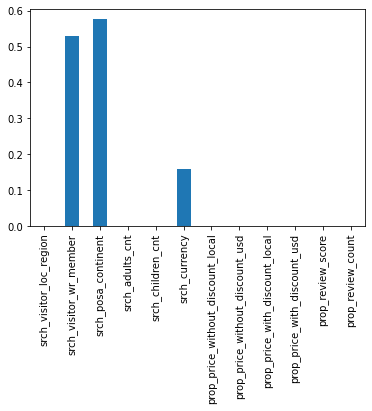

In [11]:
missing = train_data.isnull().sum()/len(train_data)
missing = missing[missing>0]
missing.plot.bar()

<AxesSubplot:>

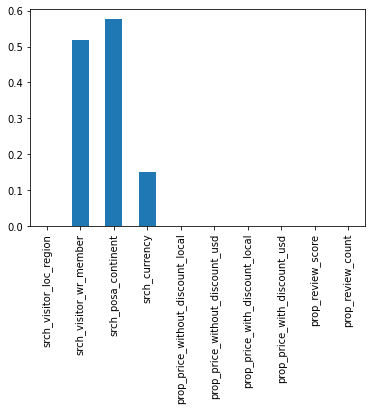

In [12]:
missing_test = test.isnull().sum()/len(test)
missing_test = missing_test[missing_test>0]
missing_test.plot.bar()

In [13]:
missing.index  # print the columns that contains null value

Index(['srch_visitor_loc_region', 'srch_visitor_wr_member',
       'srch_posa_continent', 'srch_adults_cnt', 'srch_children_cnt',
       'srch_currency', 'prop_price_without_discount_local',
       'prop_price_without_discount_usd', 'prop_price_with_discount_local',
       'prop_price_with_discount_usd', 'prop_review_score',
       'prop_review_count'],
      dtype='object')

There are 12 columns missing values and most of them have very few missing values. However, `srch_visitor_wr_member` and `srch_posa_continent` miss more than 50% of values and `srch_currency` miss around 17% of values.

### Dataset Summary

In [14]:
train_data.describe()

,srch_id,prop_key,srch_visitor_visit_nbr,srch_hcom_destination_id,srch_dest_longitude,srch_dest_latitude,srch_ci_day,srch_co_day,srch_los,srch_bw,...,prop_price_with_discount_usd,prop_imp_drr,prop_brand_bool,prop_starrating,prop_market_id,prop_submarket_id,prop_room_capacity,prop_review_score,prop_review_count,prop_hostel_bool
count,8.411150e+05,8.411150e+05,841115.000000,8.411150e+05,841115.000000,841115.000000,841115.000000,841115.000000,841115.000000,841115.000000,...,8.410640e+05,841115.000000,841115.000000,841115.000000,841115.000000,841115.000000,841115.000000,841107.000000,841107.000000,841115.000000
mean,1.724233e+07,8.185569e+05,12.325977,1.194309e+06,-45.892803,40.445932,4.272102,3.689650,2.677238,35.349157,...,3.044565e+02,0.425998,0.664118,3.595627,71586.980101,106494.270656,631.116457,4.024048,2160.753578,0.002888
std,1.231757e+09,1.141255e+06,31.788936,4.237267e+05,77.706051,6.056537,2.003199,2.128168,2.192103,49.506785,...,4.205190e+03,0.494494,0.472298,0.864574,39165.985756,7384.185494,1573.071335,0.547170,3075.169206,0.053661
min,-2.147275e+09,2.407460e+05,1.000000,5.042610e+05,-115.172875,28.541290,1.000000,1.000000,1.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,369.000000,60556.000000,-9998.000000,0.000000,0.000000,0.000000
25%,-1.034005e+09,2.559520e+05,1.000000,7.267840e+05,-115.172875,36.114666,3.000000,2.000000,1.000000,4.000000,...,9.902000e+01,0.000000,0.000000,3.000000,60039.000000,98238.000000,144.000000,3.800000,306.000000,0.000000
50%,3.193952e+07,2.777420e+05,3.000000,1.497539e+06,-73.986473,40.756680,5.000000,4.000000,2.000000,17.000000,...,1.890000e+02,0.000000,1.000000,4.000000,95602.000000,109153.000000,306.000000,4.100000,937.000000,0.000000
75%,1.081646e+09,4.781330e+05,10.000000,1.504033e+06,-0.127804,41.880779,6.000000,6.000000,3.000000,46.000000,...,2.990000e+02,1.000000,1.000000,4.000000,95656.000000,110287.000000,770.000000,4.400000,2550.000000,0.000000
max,2.147266e+09,3.949856e+06,1082.000000,1.506246e+06,139.759995,51.507538,7.000000,7.000000,28.000000,473.000000,...,1.087117e+06,1.000000,1.000000,5.000000,116356.000000,116928.000000,19235.000000,5.000000,32399.000000,1.000000


`prop_room_capacity` contains negative values, which are invalid, need to be investigate.

## Data Preprocessing   
1. Deal with Nan value in the datasets
2. Process the date columns 
3. Deal with invalid value and drop some columns
4. Encode the categorical columns

In [15]:
# concate train data and test data to do data preprocessing together
features = pd.concat([train_data, test]).reset_index(drop=True) 

### Deal with NAN value 

#### 1. Fill nan value with mode    
For `srch_visitor_loc_region`, `srch_adults_cnt`, `srch_children_cnt`,`prop_price_without_discount_local`, `prop_price_without_discount_usd`, `prop_price_with_discount_local`, `prop_price_with_discount_usd`, `prop_review_score`,`prop_review_count`, we will fill nan value with mode, since they only contain a small number of NAN value

In [16]:
def filll_nan_mode(data,cols):
    for col in cols:
        data[col] = data[col].fillna(data[col].mode()[0])
    return data

In [17]:
excluded_cols = ['srch_visitor_wr_member', 'srch_posa_continent', 'srch_currency']
included_cols = [col for col in missing.index if col not in excluded_cols]
features = filll_nan_mode(features,included_cols)

#### 2. Drop column `srch_visitor_wr_member` 
The column `srch_visitor_wr_member` contains more than 50% of nan values and the according to the content, it is not a very important column. 

In [18]:
features['srch_visitor_wr_member'].value_counts()/len(features)   

Not Signed In|Returning Visitor|Not FC Member                0.223070
Not Signed In|New Visitor|Not FC Member                      0.107859
Signed In|WR Member|Not FC Member                            0.078277
Signed in - Persistent|WR Member|Not FC Member               0.058583
Signed in - Persistent|WR Member|Remembered FC Member        0.004071
Signed In|WR Member|FC Member                                0.001181
Signed In|Not WR Member|Not FC Member                        0.000741
Signed in - Persistent|Not WR Member|Not FC Member           0.000508
Signed in - Persistent|Not WR Member|Remembered FC Member    0.000124
Name: srch_visitor_wr_member, dtype: float64

In [19]:
features.drop(['srch_visitor_wr_member'],axis=1,inplace=True)

#### 3. Fill nan with `NORTHAMERICA`  in  column `srch_posa_continent` 
According to the analysis, the samples with nan value in the `srch_posa_continent` column contains values 'US' and 'Canada' in the `srch_posa_country` (point of sale country for a particular search), so we fill the `srch_posa_continent` with 'NORTHAMERICA'

In [20]:
features['srch_posa_continent'].value_counts()/len(features)   

EUROPE     0.248115
ASIA       0.130460
LATAM      0.037770
OCEANIA    0.006794
Name: srch_posa_continent, dtype: float64

In [21]:
# Display the srch_posa_country value in each srch_posa_continent
for region in features['srch_posa_continent'].value_counts().index:
    tmp = features[features['srch_posa_continent']==region]
    print(region)
    print(tmp['srch_posa_country'].value_counts(),'\n')

EUROPE
UNITED KINGDOM            72516
SWEDEN                    45641
FRANCE                    43591
NORWAY                    31966
EMEA                      27259
DENMARK                   19371
GERMANY                    9813
SWITZERLAND                8646
FINLAND                    7420
RUSSIA                     5390
SPAIN & CANARY ISLANDS     5240
IRELAND                    4494
ITALY                      4006
NETHERLANDS                3120
BELGIUM                    2165
SOUTH AFRICA               1670
AUSTRIA                    1025
POLAND                      812
ICELAND                     447
PORTUGAL                    347
GREECE                      284
CZECH                       191
HUNGARY                     183
ESTONIA                     134
CROATIA                      90
SLOVAKIA                     45
LATVIA                       43
LITHUANIA                     7
Name: srch_posa_country, dtype: int64 

ASIA
SOUTH KOREA                  32662
JAPAN            

In [22]:
# Display the srch_posa_country value for the samples without srch_posa_continent
tmp = features[features['srch_posa_continent'].isnull()]
tmp['srch_posa_country'].value_counts()

US        657191
CANADA     30808
Name: srch_posa_country, dtype: int64

In [23]:
features['srch_posa_continent'] = features['srch_posa_continent'].fillna('NORTHAMERICA') 

#### 4. Column `srch_currency`   
According to the definition of `srch_currency` (currency relevant for the point of sale the search was submitted form), we assume there are relationship between `srch_currency` and `srch_posa_country` (point of sale country for a particular search).    
According to the following anlaysis, we discovered that the the mode of `srch_currency` for each `srch_posa_country` is most likely to be the offcial currency of `srch_posa_country`. So that we can fill the nan value in `srch_currency` with the mode of `srch_currency` with respect to `srch_posa_country`.

In [24]:
country_currency = features.groupby(['srch_posa_country'])['srch_currency'].agg(pd.Series.mode)

In [25]:
# Show the `srch_posa_country` of samples without `srch_currency`
tmp = features[features['srch_currency'].isnull()]
tmp['srch_posa_country'].value_counts()

US                           109203
UNITED KINGDOM                11837
FRANCE                         7123
JAPAN                          5613
SOUTH KOREA                    5241
SWEDEN                         5030
CANADA                         4802
NORWAY                         4782
EMEA                           3734
BRAZIL                         3384
TAIWAN, REPUBLIC OF CHINA      3108
HONG KONG                      2910
DENMARK                        2487
ASIA                           2226
MEXICO                         1682
CHINA                          1616
SWITZERLAND                    1546
AUSTRALIA                      1465
GERMANY                        1362
IRELAND                         836
FINLAND                         816
SINGAPORE                       771
SPAIN & CANARY ISLANDS          729
INDIA                           665
ITALY                           425
COLOMBIA                        300
ISRAEL                          269
RUSSIA                      

In [26]:
dict(country_currency)

{'ARABIC': 'USD',
 'ARGENTINA': 'ARS',
 'ASIA': 'USD',
 'AUSTRALIA': 'AUD',
 'AUSTRIA': 'EUR',
 'BELGIUM': 'EUR',
 'BOLIVIA': 'BOB',
 'BRAZIL': 'BRL',
 'CANADA': 'CAD',
 'CHILE': 'CLP',
 'CHINA': 'CNY',
 'COLOMBIA': 'COP',
 'COSTA RICA': 'CRC',
 'CROATIA': 'USD',
 'CZECH': 'CZK',
 'DENMARK': 'DKK',
 'ECUADOR': 'USD',
 'EL SALVADOR': 'USD',
 'EMEA': 'USD',
 'ESTONIA': 'EUR',
 'FINLAND': 'EUR',
 'FRANCE': 'EUR',
 'FRENCH GUIANA': 'USD',
 'GERMANY': 'EUR',
 'GREECE': 'EUR',
 'GUATEMALA': 'GTQ',
 'HONDURAS': 'HNL',
 'HONG KONG': 'HKD',
 'HUNGARY': 'HUF',
 'ICELAND': 'ISK',
 'INDIA': 'INR',
 'INDONESIA': 'USD',
 'IRELAND': 'EUR',
 'ISRAEL': 'ILS',
 'ISRAEL HEBREW': 'ILS',
 'ITALY': 'EUR',
 'JAPAN': 'JPY',
 'LATVIA': 'EUR',
 'LITHUANIA': 'LTL',
 'MALAYSIA': 'MYR',
 'MEXICO': 'MXN',
 'NETHERLANDS': 'EUR',
 'NEW ZEALAND': 'NZD',
 'NICARAGUA': 'USD',
 'NORWAY': 'NOK',
 'PANAMA': 'PAB',
 'PARAGUAY': 'USD',
 'PERU': 'PEN',
 'PHILIPPINES': 'PHP',
 'POLAND': 'PLN',
 'PORTUGAL': 'EUR',
 'RUSSIA': 'R

In [27]:
features['srch_currency'] = features['srch_currency'].fillna(features['srch_posa_country'].map(dict(country_currency)))

###  Process the date columns
1. Further analysis shows that the `srch_local_date` and `srch_date_time` have high correlation, so that we drop `srch_local_date`
2. In the dataset, `srch_local_date`, `srch_ci`, `srch_co`, `srch_date_time` are date columns, we need to transfer them to year, month and day

In [ ]:
t = features[['srch_date_time','srch_local_date']]
t['srch_date_time'] =pd.to_datetime(t['srch_local_date']).dt.strftime("%Y-%m-%d")
t['srch_local_date'] =  pd.to_datetime(t['srch_local_date'])
t['is_same'] = t['srch_date_time']==t['srch_local_date']
t['is_same'].value_counts()

In [ ]:
def dateTransfer(df,col):
    '''
    Split date-like column to 3 columns which contain Year, Month and Day information.
    
    Parameters
    ----------
    df: dataframe, contain `col` feature 
    col: string, the column name of the column that need to be preocessed
    
    Return
    ----------
    df: dataframe
    '''
    
    df[col] = pd.to_datetime(df[col]) # convert string to datetime type 
    df[col+'_Year'] = pd.DatetimeIndex(df[col]).year # obtain year info
    df[col+'_Month'] = pd.DatetimeIndex(df[col]).month # obtain month info
    df[col+'_Day'] = pd.DatetimeIndex(df[col]).day # obtain day info 
    df.drop(col,inplace=True,axis=1) # drop the original date-like column
    return df

In [ ]:
features = dateTransfer(features,'srch_date_time')
features = dateTransfer(features,'srch_co')
features = dateTransfer(features,'srch_ci')

### Deal with invalid value and drop some columns

In [ ]:
features.loc[features.prop_room_capacity < 0, 'prop_room_capacity'] = 0  # replace negative value as zero 
features.loc[features.srch_posa_country =='UNKNOWN', 'srch_posa_country'] = features['srch_posa_country'].mode()[0] # replace unknown as mode
features.loc[features.srch_visitor_loc_city =='?', 'srch_visitor_loc_city'] = features['srch_visitor_loc_city'].mode()[0] # replace ? as mode

In [ ]:
features.drop('srch_local_date',inplace=True,axis=1) # contain same info as srch_date_time
features.drop('srch_visitor_id', inplace=True,axis=1) # id info can delete
features.drop('prop_price_without_discount_local', inplace=True,axis=1) # already have prop_price_without_discount_local_usd
features.drop('prop_price_with_discount_local', inplace=True,axis=1) # already have prop_price_with_discount_local_usd
features.drop('srch_mobile_bool', inplace=True,axis=1) # only contain one value

### Encode the categorical col     
 Label Encoding

In [ ]:
features.describe(exclude=[np.number])

In [ ]:
def labelEncoding(df,col):
    '''
    Split date-like column to 3 columns which contain Year, Month and Day information.
    
    Parameters
    ----------
    df: dataframe, contain `col` feature 
    col: string, the column name of the column that need to be preocessed
    
    Return
    ----------
    col_cat: mapping between category number with original value
    df: dataframe
    '''
    df[col] = df[col].astype('category')
    col_cat = dict(enumerate(df[col].cat.categories))
    df[col] = df[col].cat.codes
    return col_cat, df

In [ ]:
srch_visitor_loc_city_cat, features = labelEncoding(features,'srch_visitor_loc_city')
srch_visitor_loc_country_cat, features = labelEncoding(features,'srch_visitor_loc_country')
srch_posa_continent_cat, features =  labelEncoding(features,'srch_posa_continent')
srch_posa_country_cat, features = labelEncoding(features,'srch_posa_country')
srch_device_cat, features = labelEncoding(features,'srch_device')
srch_currency_cat,features = labelEncoding(features,'srch_currency')
prop_super_region_cat,features = labelEncoding(features,'prop_super_region')
prop_country_cat, features = labelEncoding(features,'prop_country')
prop_continent_cat,features = labelEncoding(features,'prop_continent')
srch_visitor_loc_region_cat,features = labelEncoding(features,'srch_visitor_loc_region')

# Data Visualization

In [ ]:
train_clean = features.loc[:len(train)-1,:]
train_clean['label'] = y

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(21,6))
sns.countplot('srch_ci_Year',data=train_clean.sort_values(by=['srch_ci_Year']),ax=ax[0])
sns.countplot('srch_ci_Month',data=train_clean.sort_values(by=['srch_ci_Month']),ax=ax[1])
sns.countplot('srch_ci_Day',data=train_clean.sort_values(by=['srch_ci_Day']),ax=ax[2])

Train dataset contains data of clients who checked in most in 2014 and some in 2015,  and according to the checkin month chart we discovered that Sep, Oct, Nov and Dec contain more samples, from which we might draw a conclusion that people are more like to go travel in these months

In [ ]:
sns.countplot('prop_country',data=train_clean.sort_values(by=['prop_country']))
print(prop_country_cat)

According to the chart above, we discovered that USA is the most popular country for traving in the train dataset

In [ ]:
sns.countplot('prop_starrating',data=train_clean.sort_values(by=['prop_starrating']))

According the chart above,  4-star hotels make up the majority among the hotels in train dataset. 

In [ ]:
review = train_clean[['prop_review_score']].astype(int)
sns.countplot('prop_review_score',data=review.sort_values(by=['prop_review_score']))

According the chart above, among the hotels in all datasets, hotels with a rating of around 4 make up the majority

## Modelling
1. Get the processed train dataset and test dataset 
2. Use cross-validation to select the best hyperparameters for XGBoost model 
3. Train the XGBoost with selected hyperparameters 
4. Predict the ranking in test dataset and output

### Get the processed train dataset and test dataset

In [ ]:
train_clean = features.loc[:len(train)-1,:]
train_clean['label'] = y
test_clean = features.loc[len(train):,:]
print('train data shape',train_clean.shape)
print('test data shape',test_clean.shape)

### Use cross-validation to select the best hyperparameters for XGBoost model

In [ ]:
# Split train data to X_train and X_val (validation dataset)
split = GroupShuffleSplit(test_size=.20, n_splits=1, random_state = 7).split(train_clean, groups=train['srch_id']) 
X_train_inds, X_val_inds = next(split)

train_data= train_clean.iloc[X_train_inds]
X_train = train_data.loc[:, ~train_data.columns.isin(['label'])]
y_train = train_data.loc[:, 'label']
# create groups for model fit
groups_train = train_data.groupby('srch_id').size().to_frame('size')['size'].to_numpy()


val_data= train_clean.iloc[X_val_inds]
X_val = val_data.loc[:, ~val_data.columns.isin(['label'])]
y_val = val_data.loc[:, 'label']
# create groups for model fit
groups_val= val_data.groupby('srch_id').size().to_frame('size')['size'].to_numpy()

In [ ]:
# remove the srch_id from train data
X_train.drop('srch_id',axis=1,inplace=True)
X_val.drop('srch_id',axis=1,inplace=True)

In [1]:
# Use grid search to search best hyperparameters for XGBRanker model 
n_estimators_set = [1000, 1500]
max_depth_set = [7, 8]
min_child_weight_set = [1,3]

best_score = 0  # store the best ndcg score 
opt_est = 0 # store the optimal estimator number 
opt_dep = 0 # store the optimal maximum depth 
min_child_weight = 0 # store the optimal minimum child weight

for n_estimators in n_estimators_set:
    for max_depth in max_depth_set:
        for min_child_weight in min_child_weight_set:
            print('n_estimators = ',n_estimators,)
            print('max_depth = ',max_depth,)
            print('min_child_weight = ', min_child_weight)
            model = xgb.XGBRanker(  
                tree_method='hist',
                booster='gbtree',
                objective='rank:ndcg', # Specify the learning task and the corresponding learning objective
                random_state=42, 
                learning_rate=0.05,
                colsample_bytree=0.9, # Subsample ratio of columns when constructing each tree.
                eta=0.05, 
                scale_pos_weight=32.0,
                subsample=0.75, # Subsample ratio of the training instance.
                max_depth=max_depth,  # Maximum tree depth for base learners.
                n_estimators=n_estimators, # Number of gradient boosted trees. Equivalent to number of boosting rounds.
                min_child_weight = min_child_weight #  Minimum sum of instance weight(hessian) needed in a child.
                )

            model.fit(X_train, y_train, group=groups_train, eval_set=[(X_train, y_train), (X_val, y_val)],eval_group=[groups_train,groups_val],
                    eval_metric='ndcg@50', verbose=True)
            evals_result = model.evals_result()
            score = evals_result['validation_1']['ndcg@50'][-1]
            if score>best_score:
                best_score = score
                opt_dep = max_depth
                opt_est = n_estimators
                opt_wei = min_child_weight
                print(best_score, opt_est,opt_dep,min_child_weight)

n_estimators =  1000
max_depth =  7
min_child_weight =  1


NameError: name 'xgb' is not defined

In [48]:
print('The best ndcg@50 score of validation set is {}, with the hyperparameters max_depth {},  n_estimators {} and  min_child_weight {}.'.format(best_score,opt_dep,opt_est,opt_wei))

The best ndcg@50 score of validation set is 0.653736, with the hyperparameters max_depth 8,  n_estimators 1500 and  min_child_weight 3.


In [49]:
# define the model with selected hyperparameters
opt_model = xgb.XGBRanker(  
                tree_method='hist',
                booster='gbtree',
                objective='rank:ndcg',
                random_state=42, 
                learning_rate=0.05,
                colsample_bytree=0.9, 
                eta=0.05, 
                subsample=0.75,
                max_depth=opt_dep, 
                n_estimators=opt_est, 
                min_child_weight=opt_wei
                )

In [50]:
# Use all train dataset to train the model 
total_groups = train_clean.groupby('srch_id').size().to_frame('size')['size'].to_numpy()
total_train = train_clean.drop(['label','srch_id'],axis=1)
total_y = train_clean['label']
opt_model.fit(total_train, total_y, group=total_groups)

XGBRanker(base_score=0.5, booster='gbtree', colsample_bylevel=1,
          colsample_bynode=1, colsample_bytree=0.9, enable_categorical=False,
          eta=0.05, gamma=0, gpu_id=-1, importance_type=None,
          interaction_constraints='', learning_rate=0.05, max_delta_step=0,
          max_depth=8, min_child_weight=3, missing=nan,
          monotone_constraints='()', n_estimators=1500, n_jobs=8,
          num_parallel_tree=1, objective='rank:ndcg', predictor='auto',
          random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
          subsample=0.75, tree_method='hist', validate_parameters=1,
          verbosity=None)

### Display feature importance
1. Use feature importances attribute from xgboost model 
2. Use SHAP (SHapley Additive exPlanations) to show the feature importance

<AxesSubplot:title={'center':'Feature weight'}, xlabel='F score', ylabel='Features'>

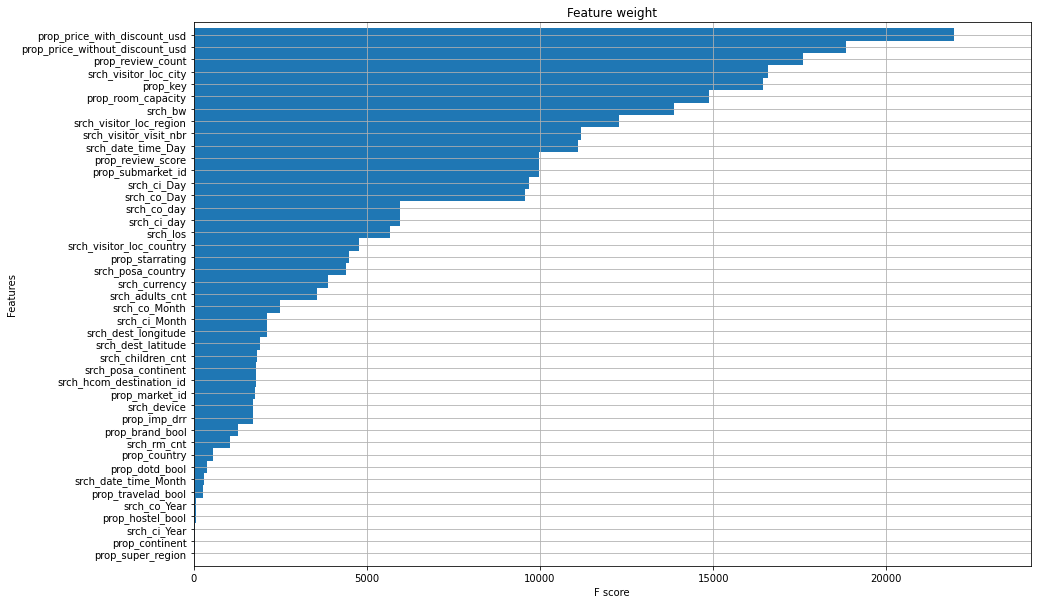

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(15,10))
xgb.plot_importance(
    booster=opt_model, 
    importance_type='weight',
    title='Feature weight',
    show_values=False,
    height=1,
    ax = ax
)

According to the chart above, `prop_price_with_disctount_usd`, `prop_price_without_disctount_usd`,`prop_review_cout` are the top 3 important features for the ranking task. 

In [52]:
shap.initjs()
X_sampled = X_train.sample(3000, random_state=10)
explainer = shap.TreeExplainer(opt_model)
shap_values = explainer.shap_values(X_sampled)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [53]:
# # visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], X_sampled.iloc[0,:])

The chart above is the shape value (-2.32) of the first sample, the value is much more smaller than base value (0.5138,the average model output over the training dataset we passed).  The above explanation shows features' contributions to push the model output from the base value. If there were any features pushing the class label higher they would be shown in red, otherwise they would be shown in blue.

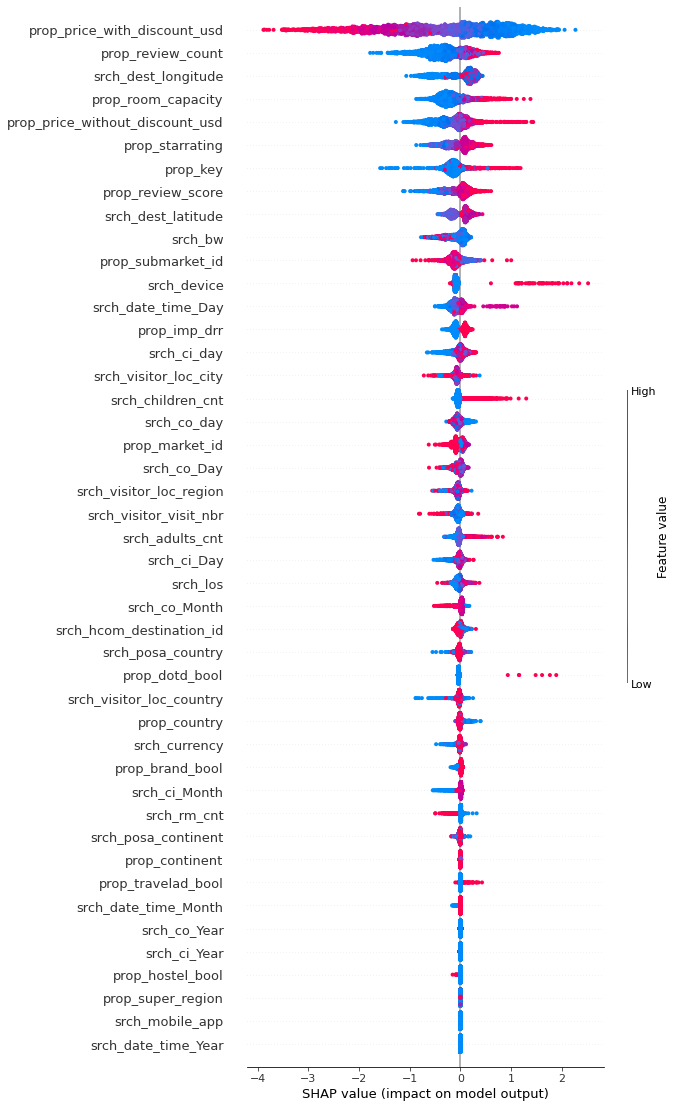

In [54]:
shap.summary_plot(shap_values, X_sampled,max_display=45)

This summary plot replaces the typical bar chart of feature importance. It tells which features are most important, and also their range of effects over the dataset. The color allows us match how changes in the value of a feature effect the change in risk (such that a high white blood cell count leads to a high risk of death).

According to the results of two method, `prop_price_with_discount_usd` and `prop_review_count` are the most important features for this ranking task. And `srch_date_time_Year`,`srch_mobile_app`,`prop_super_region` features provide least contributions to the task. 

In [ ]:
# Prediction 
test_tmp = test_clean.drop('srch_id',axis=1)
pred = opt_model.predict(test_tmp)
test_clean['pred'] = pred
results = test_clean[['srch_id', 'prop_key', 'pred']]
results_to_csv = results.sort_values(['srch_id'], ascending=True).groupby(['srch_id'], sort=False).apply(lambda x: x.sort_values(['pred'], ascending=False)).reset_index(drop=True)

In [ ]:
# Output the prediction
submissions = results_to_csv[["srch_id", "prop_key"]]
submissions.to_csv("./submission.csv", index=False)

### Final result: 
Score: 0.49114   
Ranking: 29